In [9]:
# Imports
import pandas as pd
import bs4
from bs4 import BeautifulSoup 
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_url(league_id):
    template= 'https://www.transfermarkt.com/ligue-1/transfers/wettbewerb/{}'
    url= template.format(league_id)
    return url

def get_souped_page(url):
    
    headers= {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36",
              "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1",
              "Connection":"close", "Upgrade-Insecure-Requests":"100"}
    
    page= requests.get(url, headers= headers)
    soup= BeautifulSoup(page.content, 'html.parser')
    return soup

# Convert the league_id to league name
def id_to_name(league_id):
    
    if league_id == 'GB1':
        return 'Premier League'
    elif league_id == 'ES1':
        return 'La Liga'
    elif league_id == 'L1':
        return 'Bundesliga'
    elif league_id == 'IT1':
        return 'Serie A'
    elif league_id == 'FR1':
        return 'Ligue 1'
    
# leagues ids and number of clubs competing
leagues_dict= {'GB1':20,
               'ES1':20,
               'L1':18,
               'IT1':20,
               'FR1':20}

In [3]:
def scrape_all_transfers(leagues_dict):
    
    records= []
    for key, value in leagues_dict.items():
        
        url= get_url(key)
        soup= get_souped_page(url)
        divs= soup.find_all('div', class_='box')
        clubs= divs[4:value+4]
        
        for club in clubs:
            header= club.find('h2')
            try:
                name= header.a.text
            except:
                pass
            table_bodies= club.find_all('tbody')
            
            for table in table_bodies:
                trs= table.find_all('tr')   
                
                for tr in trs:
                    
                    player= tr.a.text
                    age= tr.find('td', class_='zentriert alter-transfer-cell').text
                    nationality= tr.find('td', class_='zentriert nat-transfer-cell').img['alt']
                    position= tr.find('td', class_='pos-transfer-cell').text
                    
                    market_value= tr.find('td', class_='rechts mw-transfer-cell').text
                    
                    # In the sake of cleaning data
                    if "m" in market_value:
                        market_value = int( float(market_value.strip().replace("€","").replace("m","")) * 1000000 )
                    elif "Th." in market_value:
                        market_value = int(market_value.strip().replace("€","").replace("Th.","")) * 1000
                    elif "-":
                        market_value = 0
                        
                    try:
                        left= tr.find('td', class_='no-border-links verein-flagge-transfer-cell').a.text
                    except:
                        pass
                    
                    fee= tr.find_all('td', class_='rechts')[1].a.text
                    if "Loan fee" in fee:
                        type_transfer= 'Loan'
                        fee= fee.replace('Loan fee:','')
                    else:
                        type_transfer= 'Transfer'
                    
                    if "m" in fee:
                        fee = int( float(fee.strip().replace("€","").replace("m","")) * 1000000 )
                    elif "Th." in fee:
                        fee = int(fee.strip().replace("€","").replace("Th.","")) * 1000                        
                    elif "-":
                        fee = 0

                    
                    competition= id_to_name(key)
                    if table_bodies.index(table)==0:
                        record= [player, age, nationality, position, market_value, left, name, fee, type_transfer, competition]
                    else:
                        record= [player, age, nationality, position, market_value, name, left, fee, type_transfer, competition]

                    records.append(record)
                    
    with open("transfers_data.csv", 'w', newline='', encoding='utf-8') as f:
        writer= csv.writer(f)
        writer.writerow(['Player', 'Age', 'Nationality', 'Position', 'Market Value', 'From',
                         'To', 'Fee', 'Type of Transfer','Competition'])
        writer.writerows(records)
        
    return records


In [4]:
# Let's scrape some transfers data
data= scrape_all_transfers(leagues_dict)

In [8]:
df= pd.read_csv('transfers_data.csv')
df

,Player,Age,Nationality,Position,Market Value,From,To,Fee,Type of Transfer,Competition
0,Moussa Diaby,24,France,Right Winger,50000000,B. Leverkusen,NaN,55000000,Transfer,Premier League
1,Pau Torres,26,Spain,Centre-Back,45000000,Villarreal,NaN,33000000,Transfer,Premier League
2,Nicolò Zaniolo,24,Italy,Attacking Midfield,27000000,Galatasaray,NaN,5000000,Loan,Premier League
3,Youri Tielemans,26,Belgium,Central Midfield,25000000,Leicester,NaN,0,Transfer,Premier League
4,Clément Lenglet,28,France,Centre-Back,10000000,Barcelona,NaN,0,Transfer,Premier League
...,...,...,...,...,...,...,...,...,...,...
2994,Lenny Joseph,22,France,Centre-Forward,0,NaN,Grenoble,0,Transfer,Ligue 1
2995,Sofiane Alakouch,25,Morocco,Right-Back,0,NaN,Paris FC,0,Transfer,Ligue 1
2996,Vagner,27,Cape Verde,Right Winger,0,NaN,Without Club,0,Transfer,Ligue 1
2997,Papa Ndiaga Yade,23,Senegal,Left Winger,1200000,NaN,QRM,0,Transfer,Ligue 1


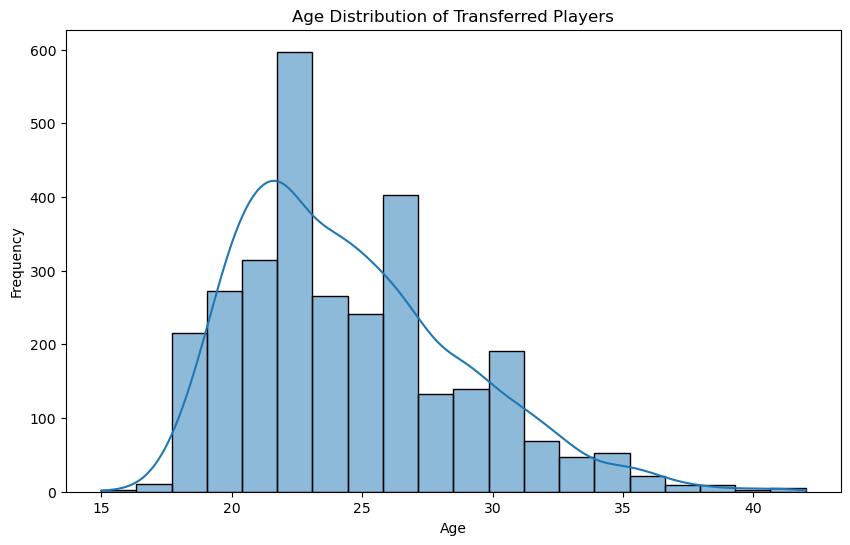

In [10]:
#-------> Visualization 1: Age Distribution of Transferred Players
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', bins=20, kde=True)
plt.title('Age Distribution of Transferred Players')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

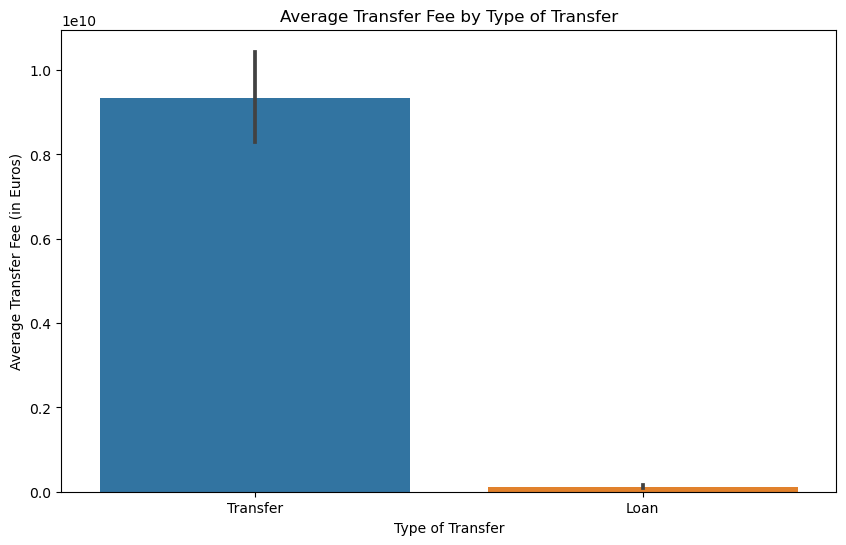

In [11]:
#---------> Visualization 2: Average Transfer Fee by Type of Transfer
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Type of Transfer', y='Fee', estimator=sum)
plt.title('Average Transfer Fee by Type of Transfer')
plt.xlabel('Type of Transfer')
plt.ylabel('Average Transfer Fee (in Euros)')
plt.show()

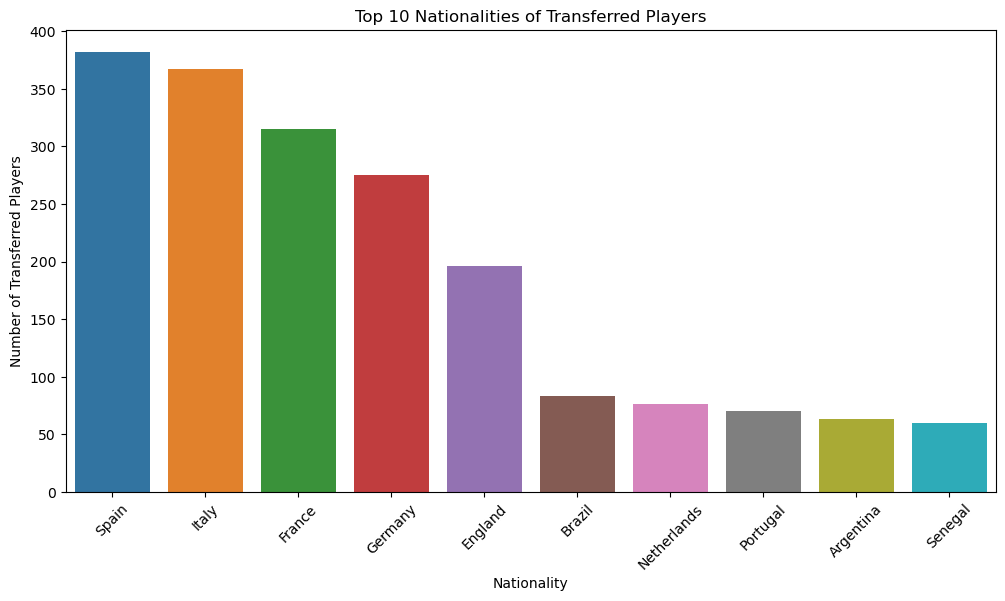

In [12]:
#----------------> Visualization 3: Top 10 Nationalities of Transferred Players
top_10_nationalities = df['Nationality'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_nationalities.index, y=top_10_nationalities.values)
plt.title('Top 10 Nationalities of Transferred Players')
plt.xlabel('Nationality')
plt.ylabel('Number of Transferred Players')
plt.xticks(rotation=45)
plt.show()

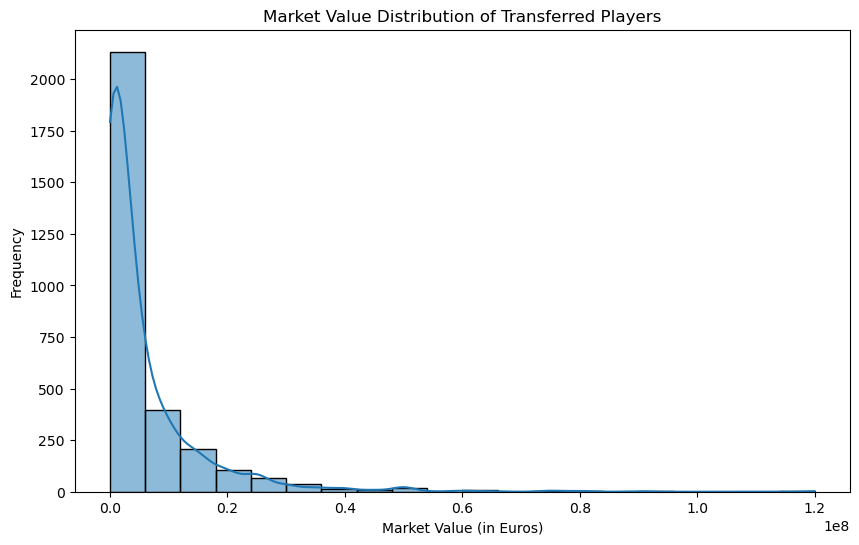

In [13]:
#---------------> Visualization 4: Market Value Distribution of Transferred Players
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Market Value', bins=20, kde=True)
plt.title('Market Value Distribution of Transferred Players')
plt.xlabel('Market Value (in Euros)')
plt.ylabel('Frequency')
plt.show()


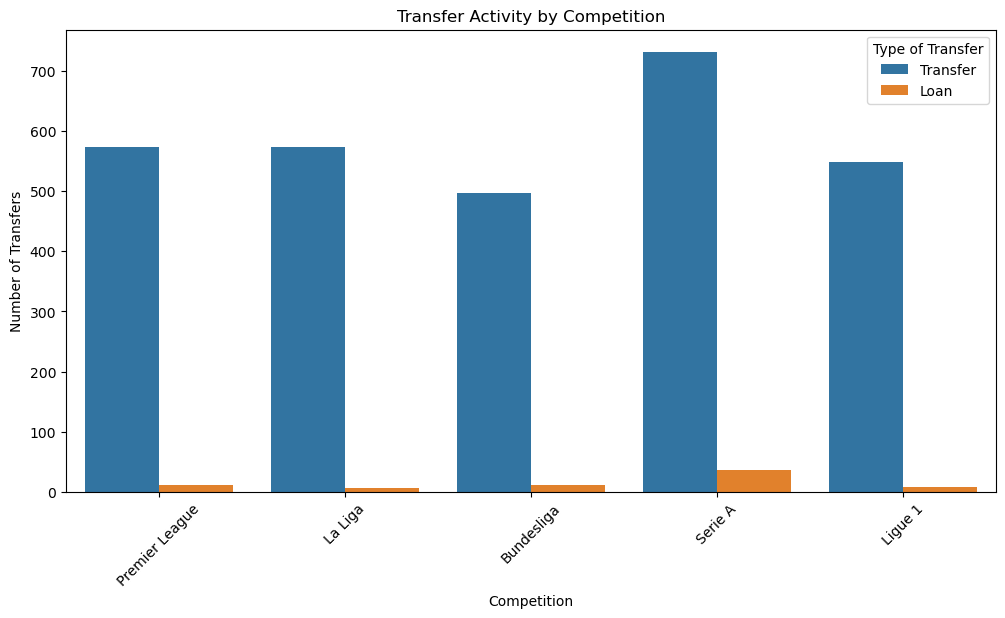

In [14]:
#-------------------> Visualization 5: Transfer Activity by Competition
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Competition', hue='Type of Transfer')
plt.title('Transfer Activity by Competition')
plt.xlabel('Competition')
plt.ylabel('Number of Transfers')
plt.xticks(rotation=45)
plt.legend(title='Type of Transfer')
plt.show()


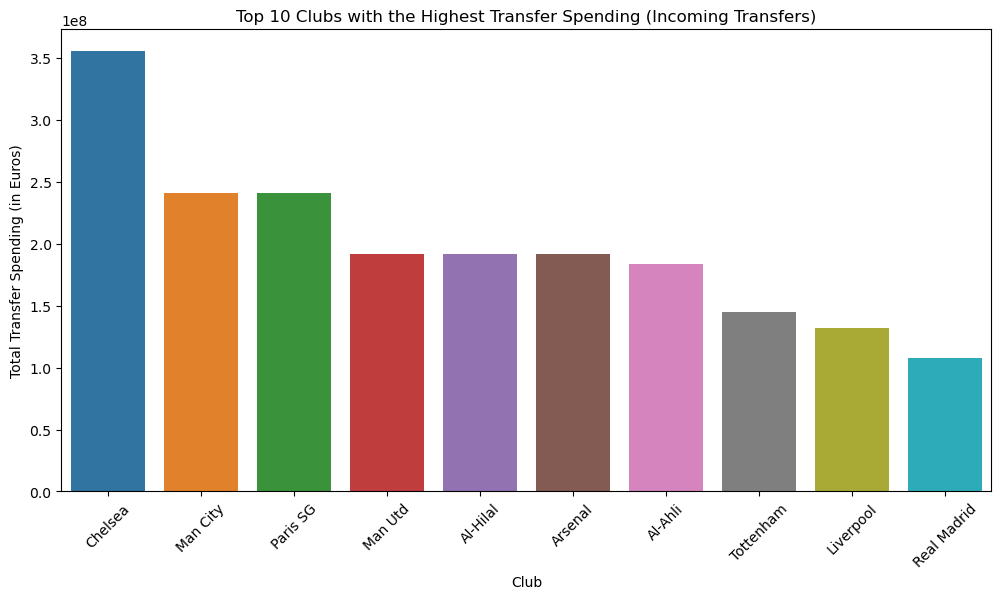

In [16]:
#---------------> Visualization 6: Top 10 Clubs with the Highest Transfer Spending
plt.figure(figsize=(12, 6))
top_10_clubs = df[df['Type of Transfer'] == 'Transfer'].groupby('To')['Fee'].sum().nlargest(10)
sns.barplot(x=top_10_clubs.index, y=top_10_clubs.values)
plt.title('Top 10 Clubs with the Highest Transfer Spending (Incoming Transfers)')
plt.xlabel('Club')
plt.ylabel('Total Transfer Spending (in Euros)')
plt.xticks(rotation=45)
plt.show()


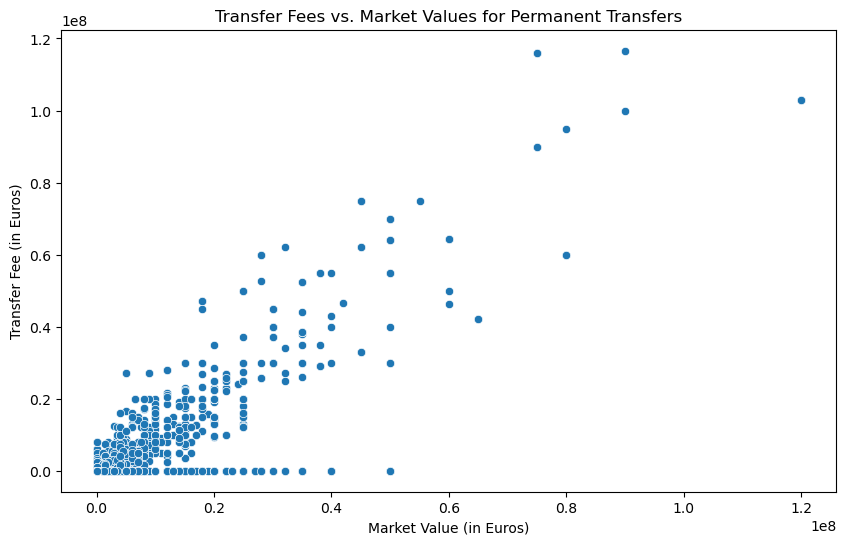

In [17]:
#------------------> Visualization 7: Transfer Fees vs. Market Values Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df['Type of Transfer'] == 'Transfer'], x='Market Value', y='Fee')
plt.title('Transfer Fees vs. Market Values for Permanent Transfers')
plt.xlabel('Market Value (in Euros)')
plt.ylabel('Transfer Fee (in Euros)')
plt.show()


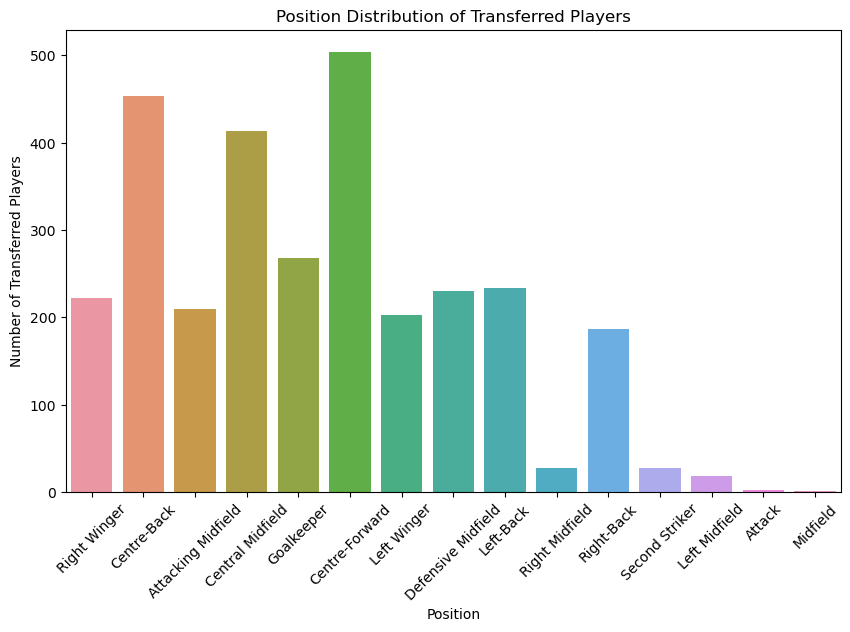

In [18]:
#-----------------> Visualization 8: Position Distribution of Transferred Players
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Position')
plt.title('Position Distribution of Transferred Players')
plt.xlabel('Position')
plt.ylabel('Number of Transferred Players')
plt.xticks(rotation=45)
plt.show()


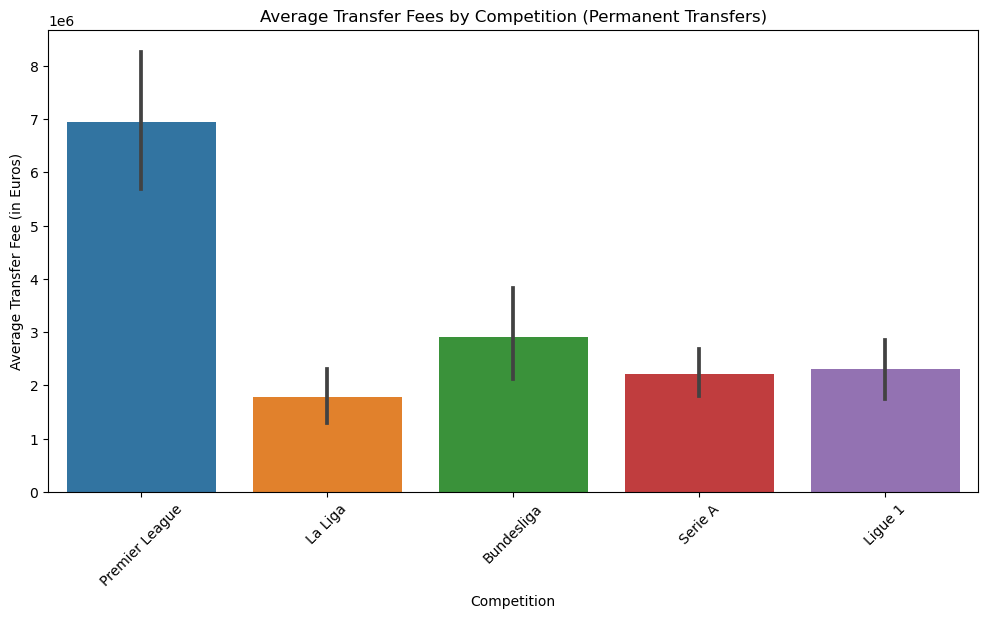

In [19]:
#-------------------> Visualization 9: Average Transfer Fees by Competition
plt.figure(figsize=(12, 6))
sns.barplot(data=df[df['Type of Transfer'] == 'Transfer'], x='Competition', y='Fee', estimator='mean')
plt.title('Average Transfer Fees by Competition (Permanent Transfers)')
plt.xlabel('Competition')
plt.ylabel('Average Transfer Fee (in Euros)')
plt.xticks(rotation=45)
plt.show()


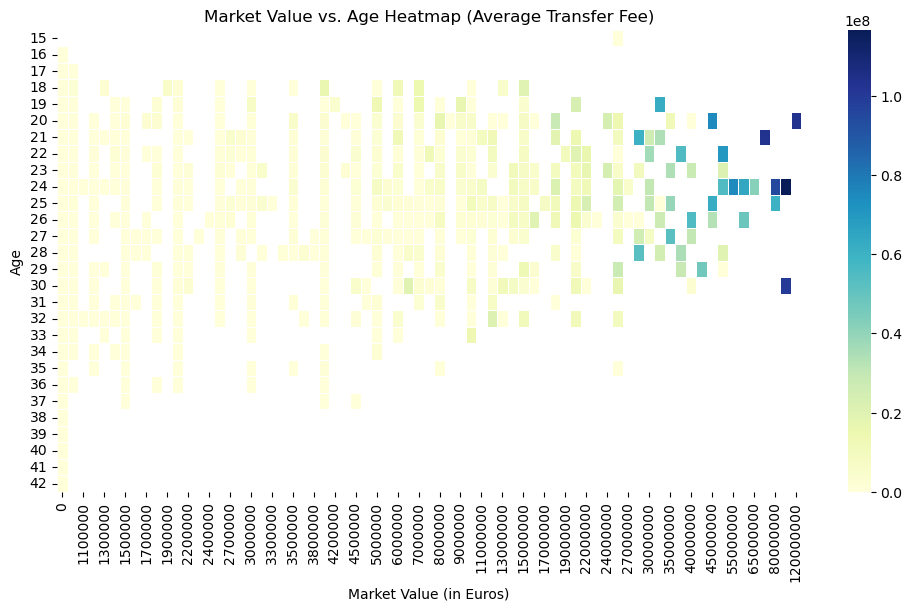

In [20]:
#-------------------> Visualization 10: Market Value vs. Age Heatmap
pivot_table = df.pivot_table(index='Age', columns='Market Value', values='Fee', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=.5)
plt.title('Market Value vs. Age Heatmap (Average Transfer Fee)')
plt.xlabel('Market Value (in Euros)')
plt.ylabel('Age')
plt.show()
